In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from tqdm import tqdm
from sklearn.model_selection import KFold
from sklearn.linear_model import Ridge, RidgeCV
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt

plt.rcParams['font.sans-serif'] = ["Helvetica"]
plt.rcParams['font.size'] = 24


In [2]:
df = pd.read_csv('./data/camcan/camcan_all.csv')

df = df.dropna(subset=['age'])

In [3]:
vessel_features = df.columns[:16].tolist()
cortical_features = df.columns[17:79].tolist()
vessel_features.remove('tortuosity_list')
vessel_features.remove('branch_list')
vessel_features.remove('radius_list')
vessel_features.remove('sub_id')


In [4]:
def get_formula(pred, features):
    formula = pred + ' ~ '
    for feature in features:
        formula += feature + ' + '
    return formula[:-3]

def fit_ols(df, pred, features):
    formula = get_formula(pred, features)
    model = sm.OLS.from_formula(formula, data=df)
    result = model.fit()
    return result

def k_fold_cross_validation(df, sub_id_col, target, features, k=10, return_models=False):
    kf = KFold(n_splits=k)
    predictions = pd.Series(index=df.index, dtype=float)
    models = []
    for train_index, test_index in kf.split(df):
        train = df.iloc[train_index]
        test = df.iloc[test_index]
        result = fit_ols(train, target, features)
        predictions.iloc[test_index] = result.predict(test)
        models.append(result)

    result_df = pd.DataFrame({
        'sub_id': df[sub_id_col],
        'target': df[target],
        'predicted': predictions
    })

    if return_models:
        return result_df, models
    else:
        return result_df

def k_fold_cross_validation_ridge(df, sub_id_col,
                                  target, features,
                                  k=10, return_models=False,
                                  alpha=1.0):
    kf = KFold(n_splits=k)
    predictions = pd.Series(index=df.index, dtype=float)
    models = []
    for train_index, test_index in kf.split(df):
        train = df.iloc[train_index]
        test = df.iloc[test_index]

        # Fit Ridge regression
        ridge = RidgeCV()
        ridge.fit(train[features], train[target])

        # Predict
        predictions.iloc[test_index] = ridge.predict(test[features])
        models.append(ridge)
    result_df = pd.DataFrame({
        'sub_id': df[sub_id_col],
        'target': df[target],
        'predicted': predictions,
    })

    if return_models:
        return result_df, models
    else:
        return result_df

In [5]:
results_kfold_vessel, models_vessel = k_fold_cross_validation_ridge(df, 'sub_id', 'age', vessel_features, k=10, return_models=True)
results_kfold_cortical, models_cortical = k_fold_cross_validation_ridge(df, 'sub_id', 'age', cortical_features, k=10, return_models=True)
results_kfold_both, models_both = k_fold_cross_validation_ridge(df, 'sub_id', 'age', vessel_features + cortical_features, k=10, return_models=True)

In [6]:
def plot_target_vs_predicted(df, ax, target_col='target',
                             predicted_col='predicted',
                             xlabel='Actual Age',
                             ylabel='Predicted Age',
                             title='Actual Age vs Predicted Age',
                             save_path=None,
                             x_range=None,
                             y_range=None,
                             color_by='dice'):

    r2score = r2_score(df[target_col], df[predicted_col])
    # plt.figure(figsize=(10, 8))
    if x_range is not None:
        ax.set_xlim.xlim(x_range)
    if y_range is not None:
        ax.set_ylim(y_range)
    ax.scatter(df[target_col], df[predicted_col], alpha=0.5, s=100)
    ax.plot([0, 100],
            [0, 100],
            color='black', linestyle='--', linewidth=2)
    ax.set_xlabel(xlabel, fontsize=24)
    ax.text(-0.05, 1.08, title,
             transform=ax.transAxes,
             fontsize=36,
             verticalalignment='top')
    ax.text(0.05, 0.95, f'$R^2$ = {r2score:.2f}',
             transform=ax.transAxes,
             fontsize=24,
             verticalalignment='top')

    ax.set_aspect('equal', adjustable='box')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_bounds(0, 100)
    ax.spines['left'].set_bounds(0, 100)
    ax.tick_params(axis='x', labelsize=24)
    ax.tick_params(axis='y', labelsize=24)
    # Calculate and return R² score
    return r2score

Text(0, 0.5, 'Predicted age')

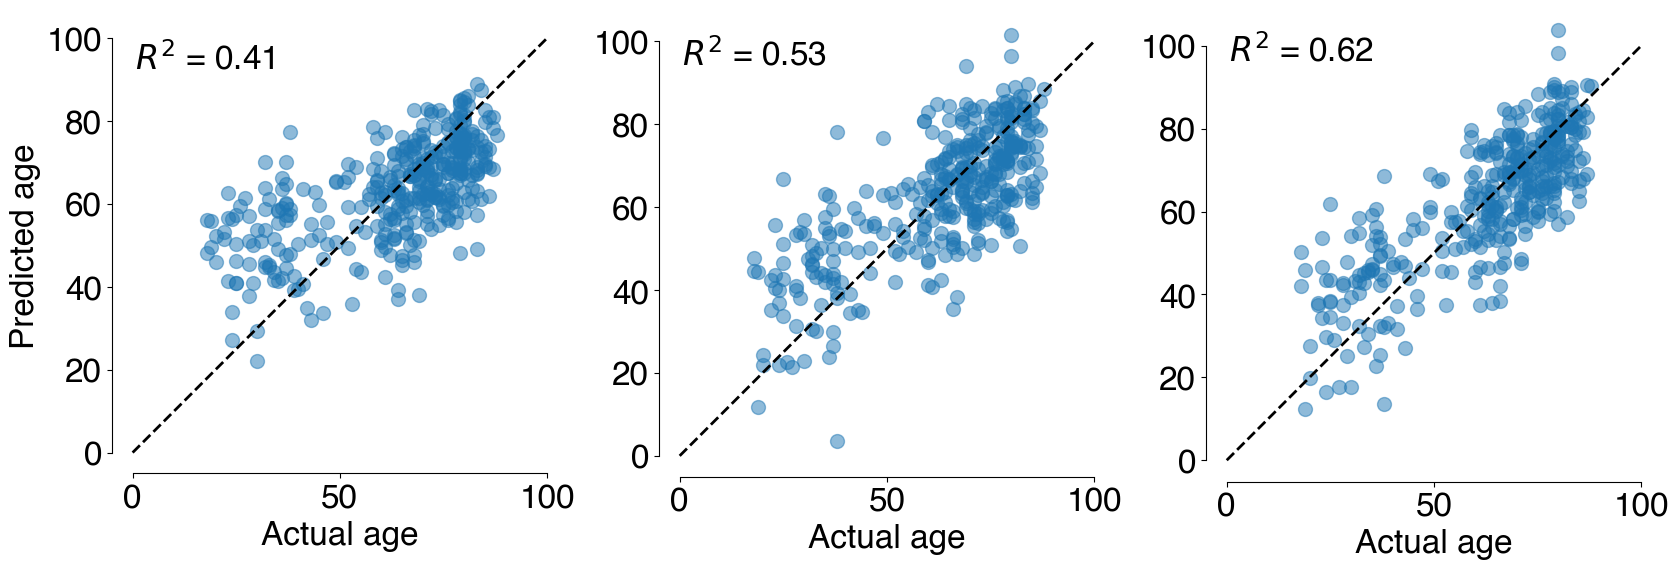

In [7]:

fig, ax = plt.subplots(1, 3, figsize=(20, 8))

plot_target_vs_predicted(results_kfold_vessel, ax[0], target_col='target',
                         predicted_col='predicted', xlabel='Actual age', ylabel='Predicted Age', title='')

plot_target_vs_predicted(results_kfold_cortical, ax[1], target_col='target',
                         predicted_col='predicted', xlabel='Actual age', ylabel='Predicted Age', title='')

plot_target_vs_predicted(results_kfold_both, ax[2], target_col='target',
                         predicted_col='predicted', xlabel='Actual age', ylabel='Predicted Age', title='')

ax[0].set_ylabel("Predicted age", fontsize=24)